# ホテルキャンセル予約予測分析


```
各ソース機能に切り出す前のNotebookの例です。
機能をnotebook上に実装する際の参考にしてください。
"./src"の処理は以下に実装した機能をpythonファイルに切り出したものです。
```


# 機能・ロジックの実装

## データ読み込み

In [ ]:
# interface: (model_loader.py)
import joblib

def save_model(model, file_path):

    joblib.dump(model, file_path)

def load_model(file_path):

    model = joblib.load(file_path)
    
    return model

## 学習

In [210]:
# config: (model_config.py)
SEED = {
    "random_state": 123 
}

DATASET_CONF = {
        "test_size":0.2,
        "target_col_name":"booking_status"
}

MODEL_PARAMS = {
    "max_depth":7,
    "min_samples_split":2,
    "random_state":150,
    "max_leaf_nodes":10
}

In [211]:
# usecase:(model_training.py)
from sklearn.tree import DecisionTreeClassifier


def split_dataset(dataset_df, test_size=0.2, random_state=100):
    
    random_state = SEED["random_state"]

    split_point = int(len(dataset_df) * test_size)
    dataset_df = dataset_df.sample(frac=1, random_state=random_state)

    train_df = dataset_df.iloc[:split_point]
    test_df = dataset_df.iloc[split_point:]

    return train_df, test_df


def get_xy_dataset(data_df, target_col_name = "booking_status"):

    x_df = data_df.drop([target_col_name], axis=1)
    y_df = data_df[target_col_name]

    return x_df, y_df


def train_model(train_x, train_y):

    model = DecisionTreeClassifier(**MODEL_PARAMS)
    model.fit(train_x, train_y)

    return model, (train_x, train_y)


def train(dataset_df):

    test_size = DATASET_CONF["test_size"]
    target_col_name = DATASET_CONF["target_col_name"]
    
    train_df, test_df = split_dataset(dataset_df, test_size)

    train_x, train_y = get_xy_dataset(train_df, target_col_name = target_col_name)
    test_x, test_y = get_xy_dataset(test_df, target_col_name = target_col_name)

    model, _ = train_model(train_x, train_y)

    return model, train_x, train_y, test_x, test_y


def train_and_save_model(dataset_df, file_path):

    model, train_x, train_y, test_x, test_y = train(dataset_df)
    save_model(model, file_path)

    return model, (train_x, train_y, test_x, test_y)



## 推論

In [212]:
# usecase: (model_predict.py)

def pred_model(model, x_df):
    
    pred_y = model.predict(x_df)
    return pred_y


## 評価

In [213]:
# usecase: (model_eval.py)
from sklearn.metrics import accuracy_score, precision_score, recall_score

def calculate_evaluation(y, pred_y):

    # 正解率の計算
    accuracy = accuracy_score(y, pred_y)
    # 適合率の計算
    precision = precision_score(y, pred_y)
    # 再現率の計算
    recall = recall_score(y, pred_y)
   
    evaluation_score = {
        "accuracy"  :accuracy,
        "precision" :precision,
        "recall"    :recall
    }
    
    return evaluation_score

## データ可視化


In [214]:
# usecase: (data_visualizer.py)
from sklearn import tree

from matplotlib import pyplot as plt
import numpy as np

def plot_feature_importances(model, x):
    # 特徴量の重要度の棒グラフ
    
    feature = model.feature_importances_
    label = x.columns
    indices = np.argsort(feature)

    fig =plt.figure (figsize = (10,10))

    plt.barh(range(len(feature)), feature[indices])

    plt.yticks(range(len(feature)), label[indices], fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("Feature", fontsize=18)
    plt.xlabel("Feature Importance", fontsize=18)


def visualize_tree(model, feature_colmuns):

    tree.plot_tree(model, feature_names=feature_colmuns, filled=True)
    plt.show()

-----

# モデルの学習と評価

In [1]:
import pandas as pd

In [215]:
# entities: (constants.py)
import datetime

t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)

# 入力データ
dataset_path = "./data/raw/dataset.csv"

# 保存先のディレクトリ
result_dir = "./data/result"
preprocessed_dir = f"{result_dir}/preprocess"
model_dir = f"{result_dir}/model"

# ファイル名のprefix/surfix
version = "ver1"
date_jst = now.strftime('%Y%m%d%H%M%S')


In [ ]:
# config: (model_config.py)
SEED = {
    "random_state": 123 
}

DATASET_CONF = {
        "test_size":0.2,
        "target_col_name":"booking_status"
}

MODEL_PARAMS = {
    "max_depth":7,
    "min_samples_split":2,
    "random_state":150,
    "max_leaf_nodes":10
}

In [223]:
# 保存先のファイルパス
model_fpath =  f"{model_dir}/model_{version}_{date_jst}"

# 前処理後のデータセットのパス
date_ = "20240618194503"
preprocess_fpath = f"{preprocessed_dir}/preprocessed_dataset_{version}_{date_}.csv"

# 前処理後のデータ読み込み
preproc_df = pd.read_csv(preprocess_fpath)

# 学習(Hold-outで簡単に学習)
model, (train_x, train_y, test_x, test_y) = train_and_save_model(preproc_df, model_fpath)

# 推論
pred_train_y = pred_model(model, train_x)
pred_test_y = pred_model(model, test_x)

# 精度評価
train_eval = calculate_evaluation(train_y, pred_train_y)
test_eval = calculate_evaluation(test_y, pred_test_y)

print(f"train_eval: {train_eval}")
print(f"test_eval: {test_eval}")

train_eval: {'accuracy': 0.8027210884353742, 'precision': np.float64(0.8), 'recall': np.float64(0.9615384615384616)}
test_eval: {'accuracy': 0.7195945945945946, 'precision': np.float64(0.776), 'recall': np.float64(0.8778280542986425)}


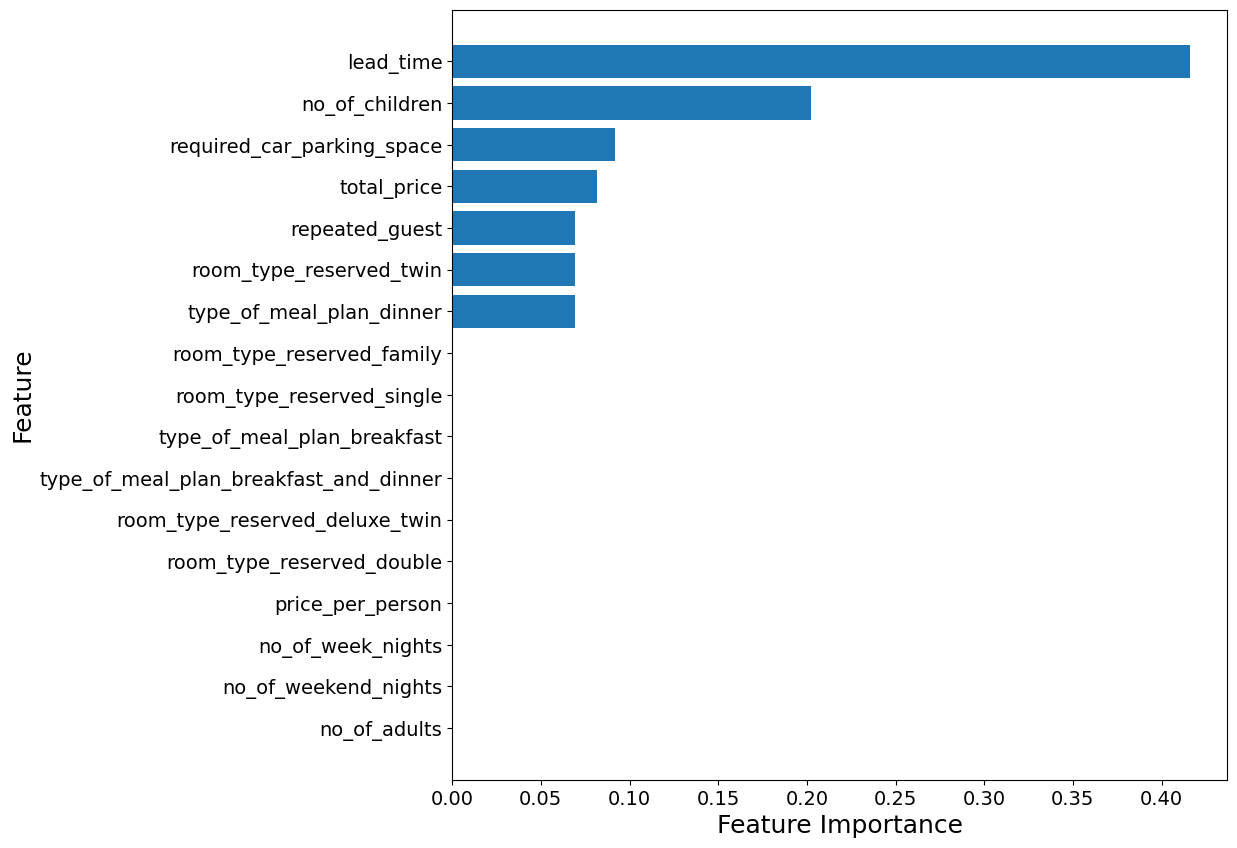

In [217]:
# 結果の可視化
plot_feature_importances(model, train_x)

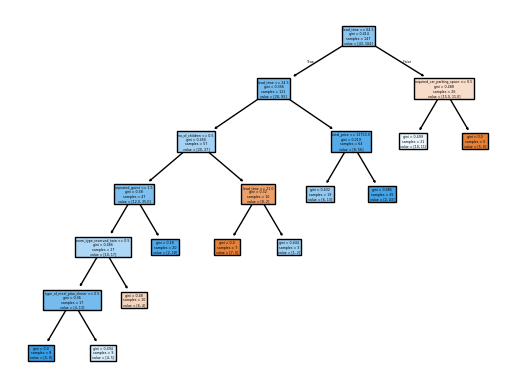

In [218]:
visualize_tree(model, train_x.columns)